In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import datetime

In [ ]:
contacts = pd.read_csv('/work/contacts.tsv', sep='\t')
searches = pd.read_csv('/work/searches.tsv', sep='\t')
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_length'] = (contacts['ds_checkout'] - contacts['ds_checkin']).dt.days
contacts['advance'] = (contacts['ds_checkin'] - contacts['ts_booking_at'].dt.normalize()).dt.days

searches = searches.drop(columns='filter_neighborhoods')

In [ ]:
contacts = contacts[contacts['advance'] >= 0]
contacts = contacts[contacts['ds_length'] <= 60]
booked = contacts[contacts['ts_booking_at'].notna()]

The following blocks of code were an attempt at data cleaning. We noticed that some people had bookings that overlapped in days whether it be a partial overlap by a day or two or multiple bookings with differing id_host and id_listing with the exact say check in and check out dates. This attempt at resolving these inconsistencies used the following logic:

For each user with multiple bookings, check if they have any bookings that overlap. If so, only keep the most recent booking and drop the less recent bookings that overlapped with it. 

We went with this approach because our assumption is that the overlapping bookings may be bookings that have since been cancelled and the user ended up rebooking with another host or listing for the same or a similar time frame. This assumption could be inaccurate but with the information we were given, our intuition told us that this was a data cleaning challenge we should tackle as a part of this dataset.

In [ ]:
booked_duplicates = booked[booked['id_guest'].duplicated(keep=False)].sort_values(['id_guest', 'ts_booking_at'], ascending=[True, True])
booked_duplicates.head()

,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,ds_length,advance
21,00e28e80-7a51-4c59-ac04-2aa16c222572,ee0fb96a-5b8f-4f12-a888-204dc191e583,c5e09113-1208-4056-9822-2a1dd7ab43a9,2014-10-02 08:19:41,2014-10-02 09:37:12,2014-10-02 09:38:58,2014-10-02 09:38:58,2014-10-10,2014-10-13,2,6,3,8.0
22,00e28e80-7a51-4c59-ac04-2aa16c222572,f8ea93bd-f4f0-4f95-8102-09f9aeae3002,33f6f6f4-12c6-495f-b3da-a395f201f197,2014-10-04 09:32:25,2014-10-04 09:49:24,2014-10-04 09:49:58,2014-10-04 09:49:58,2014-10-10,2014-10-13,2,11,3,6.0
126,038de378-28ab-4c51-aca4-a336f92cccd7,becd48ad-623e-4821-9538-e9d8f84f1cac,dbf20ee5-e592-4659-a651-f05c10771c12,2014-10-12 15:47:35,2014-10-12 15:54:34,2014-10-12 15:54:34,2014-10-12 15:54:34,2014-11-16,2014-11-17,1,8,1,35.0
125,038de378-28ab-4c51-aca4-a336f92cccd7,6f099ef3-a069-4658-9189-22ae180bd11c,8f0a73ce-365b-47f2-93b1-546fc5f455b9,2014-10-12 14:49:24,2014-10-12 15:50:56,2014-10-12 17:12:56,2014-10-12 17:12:56,2014-10-14,2014-10-15,1,17,1,2.0
128,03b3753d-d823-48c3-a4be-68b354a383e3,3c485ed2-f5f0-4430-9ac7-db34ef092d36,3ac3c9a6-51da-404d-bd51-a49ba35f5277,2014-09-20 14:47:26,2014-09-20 21:23:18,2014-09-20 21:23:18,2014-09-20 21:23:18,2014-10-16,2014-10-17,2,4,1,26.0


In [ ]:
def keep_most_recent_booking(group):
    kept_indices = []
    group = group.reset_index()

    # Check each booking against others
    for i, current_row in group.iterrows():
        is_overlapping = False
        for j, compare_row in group.iterrows():
            if i != j and current_row['ds_checkin'] < compare_row['ds_checkout'] and current_row['ds_checkout'] > compare_row['ds_checkin']:
                is_overlapping = True
                if current_row['ts_booking_at'] < compare_row['ts_booking_at']:
                    break
        if not is_overlapping or (is_overlapping and current_row['ts_booking_at'] > group.loc[:i-1, 'ts_booking_at'].max()):
            kept_indices.append(current_row['index'])

    return group.loc[group['index'].isin(kept_indices)]

In [ ]:
booked_no_overlap = booked.groupby('id_guest').apply(keep_most_recent_booking).reset_index(drop=True)
booked_no_overlap[booked_no_overlap['id_guest'].duplicated(keep=False)]

,index,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,ds_length,advance
32,125,038de378-28ab-4c51-aca4-a336f92cccd7,6f099ef3-a069-4658-9189-22ae180bd11c,8f0a73ce-365b-47f2-93b1-546fc5f455b9,2014-10-12 14:49:24,2014-10-12 15:50:56,2014-10-12 17:12:56,2014-10-12 17:12:56,2014-10-14,2014-10-15,1,17,1,2.0
33,126,038de378-28ab-4c51-aca4-a336f92cccd7,becd48ad-623e-4821-9538-e9d8f84f1cac,dbf20ee5-e592-4659-a651-f05c10771c12,2014-10-12 15:47:35,2014-10-12 15:54:34,2014-10-12 15:54:34,2014-10-12 15:54:34,2014-11-16,2014-11-17,1,8,1,35.0
64,230,074d6096-1fce-4d2c-9f87-56494e4bf576,1d472ee4-9da9-4f70-bea3-bbd5dcacd405,f62f3cba-48d0-49b6-bf91-932f030f3933,2014-10-03 07:23:05,2014-10-03 07:25:34,2014-10-03 07:25:37,2014-10-03 08:51:51,2014-10-11,2014-10-14,4,10,3,8.0
65,231,074d6096-1fce-4d2c-9f87-56494e4bf576,1d472ee4-9da9-4f70-bea3-bbd5dcacd405,f62f3cba-48d0-49b6-bf91-932f030f3933,2014-10-03 09:03:58,2014-10-03 09:04:20,2014-10-03 09:04:20,2014-10-03 09:04:20,2014-10-16,2014-10-17,4,3,1,13.0
143,548,12de75d9-87e2-4536-bdd1-b06cd67c28b1,3e330ede-d70d-4654-a5fc-2632aee206da,9a21b968-a17e-4ec3-915c-cb0dc12a3d5e,2014-10-09 20:12:15,2014-10-09 20:12:15,2014-10-09 20:12:15,2014-10-09 20:12:15,2014-10-10,2014-10-11,1,17,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,7275,eee5d4c0-1b9a-4a11-8feb-ae1a583ca39f,f49c3095-58de-4b8d-9d5b-3bfceceb47d8,27f4b429-d544-464f-b4b5-3c09fd5992e7,2014-10-03 21:57:50,2014-10-04 12:16:24,2014-10-04 15:23:27,2014-10-04 15:23:27,2014-10-10,2014-10-12,1,11,2,6.0
1937,7378,f1942f4f-7776-4455-90d6-5e673d021930,7ad681fe-05b5-4f71-9033-c9f0cf1ab595,6ea17e16-be47-485b-a48c-ab0ccd297c9e,2014-10-08 20:41:48,2014-10-08 20:43:31,2014-10-08 20:43:31,2014-10-08 20:43:31,2014-10-29,2014-11-01,2,8,3,21.0
1938,7379,f1942f4f-7776-4455-90d6-5e673d021930,dfc3d384-6d3f-4106-9e7b-fb9df6f76ecc,5700fee7-9e3c-4ee7-961d-a1b5c81f0174,2014-10-08 21:40:15,2014-10-08 21:53:44,2014-10-08 21:53:44,2014-10-08 21:53:44,2014-11-06,2014-11-07,2,14,1,29.0
1985,7557,f7255a46-58fb-4e4d-b5f5-0f4755c64867,739f4fba-9a58-448f-932c-bba78ca936da,9f243ac6-9c51-4cb5-8ea7-5124074d5b2c,2014-10-07 17:08:52,2014-10-07 17:31:13,2014-10-07 17:31:13,2014-10-07 17:31:13,2014-10-20,2014-10-21,2,15,1,13.0


In [ ]:
print(f'{len(booked_no_overlap)} bookings')
print(f'{len(booked_no_overlap.id_guest.unique())} unique bookings')
booked_no_overlap

2050 bookings
2004 unique bookings


,index,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,ds_length,advance
0,0,000dfad9-459b-4f0b-8310-3d6ab34e4f57,13bb24b8-d432-43a2-9755-5ea11b43bb69,21d2b1a2-fdc3-4b4c-a1f0-0eaf0cc02370,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-13,2014-10-15,2,13,2,9.0
1,1,00197051-c6cb-4c3a-99e9-86615b819874,46aa3897-9c00-4d76-ac66-a307593d0675,fb5ed09a-9848-4f2c-b2ef-34deb62164fb,2014-11-04 09:10:03,2014-11-04 09:45:50,2014-11-04 09:45:50,2014-11-04 12:20:46,2014-11-27,2014-11-30,1,10,3,23.0
2,4,0027538e-aa9e-4a02-8979-b8397e5d4cba,ac162061-55e2-4072-ac91-2e080f9581f2,ec68e0af-b0f2-42c7-b6f8-d41061c083ff,2014-10-10 15:22:26,2014-10-10 15:24:26,2014-10-10 15:24:26,2014-10-10 15:52:42,2014-10-17,2014-10-19,2,14,2,7.0
3,9,007a3626-1c7b-44a9-8407-52c0f3f6cf49,ed4291f5-78e2-4654-9c76-7fdc36af0469,30550df2-1a2c-4969-95cc-2e30e4324b20,2014-12-29 18:44:50,2014-12-29 18:51:05,2014-12-31 11:53:55,2015-01-20 10:03:12,2015-02-13,2015-02-16,2,10,3,24.0
4,11,007b4c4e-261d-4db9-b5cc-5a824e9f2abc,6fccecd2-5a89-4832-856e-cb45f477f7bd,2ce4f20d-13b8-4960-b446-72ffc698b65f,2014-10-15 17:43:32,2014-10-15 17:43:32,2014-10-15 17:43:32,2014-10-15 17:43:32,2014-11-08,2014-11-15,2,26,7,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,7793,ff710267-dff4-4347-8afb-959eec0b4b6c,d60d6ea6-6daf-4b6d-8398-5af2dcd30d13,84f8c41c-0c5b-45a5-a39e-3db0ba3bc655,2014-10-11 17:23:52,2014-10-11 23:28:38,2014-10-12 17:12:14,2014-10-12 18:55:49,2014-10-13,2014-10-31,1,29,18,1.0
2046,7794,ff736829-5f30-43d6-ad32-4d6550dd9d5b,5adc72a1-22fe-4f75-a51f-551e79b36004,2f791557-f2d1-45da-aa3d-dda5be58a9e1,2014-10-09 00:02:51,2014-10-09 12:24:16,2014-10-09 12:24:16,2014-10-09 12:24:16,2014-11-08,2014-11-09,1,17,1,30.0
2047,7795,ffb3cf62-904a-4e49-baad-f8d835f18aa1,4f351532-59dc-4706-898a-0c4d25f1b125,94c2dc52-f0f4-409c-9c3d-af36e152f9d9,2014-10-13 14:53:57,2014-10-13 15:04:00,2014-10-13 15:04:00,2014-10-13 15:04:00,2014-11-08,2014-11-09,2,5,1,26.0
2048,7809,ffdf7f20-8d0f-4801-8f73-3b00a1bba4c3,71f1d49e-2ff4-4d72-b8e6-fd4c67feaa74,95fb78ca-8e6e-436a-9830-949d995ad14f,2014-10-08 13:49:00,2014-10-08 15:36:22,2014-10-08 15:36:22,2014-10-15 22:15:51,2014-11-18,2014-11-22,2,15,4,34.0


In [ ]:
search_counts = searches.groupby('id_user').size().reset_index(name='search_count')

<AxesSubplot: xlabel='advance', ylabel='Density'>

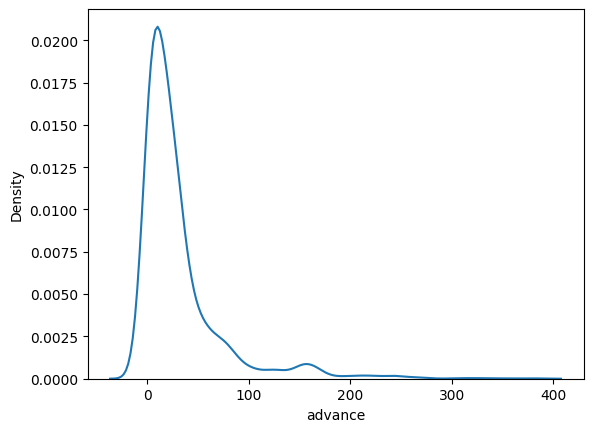

In [ ]:
sns.kdeplot(contacts['advance'])

<AxesSubplot: xlabel='advance', ylabel='Density'>

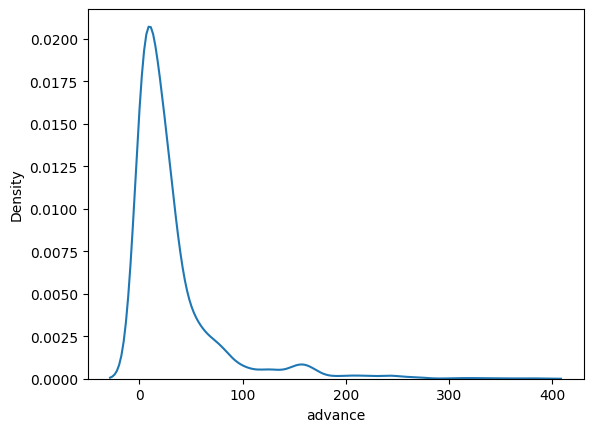

In [ ]:
sns.kdeplot(booked_no_overlap['advance'])

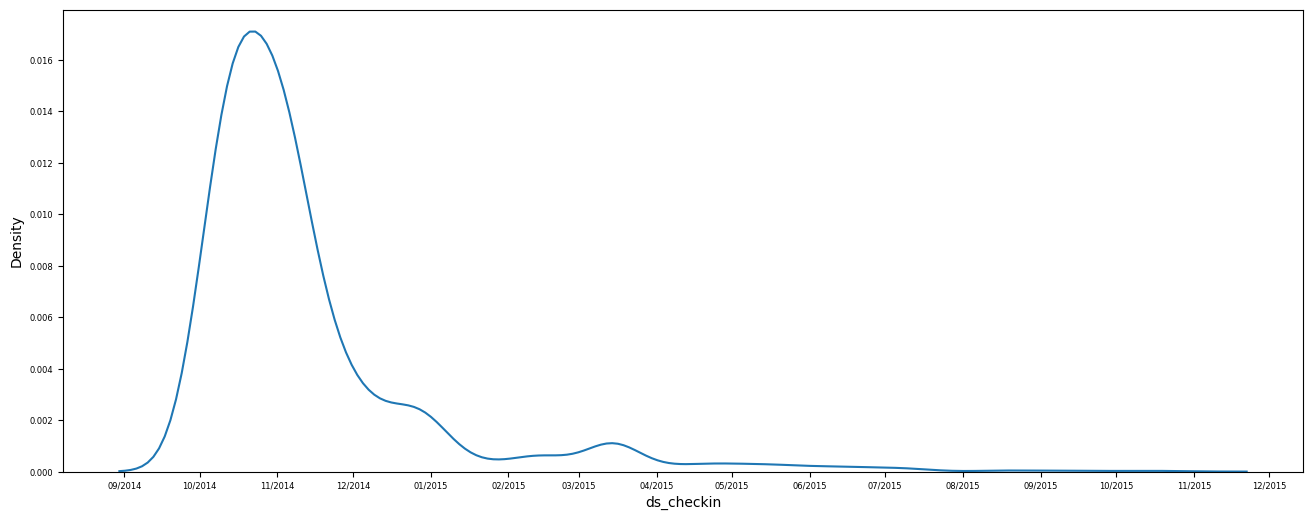

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.kdeplot(booked_no_overlap['ds_checkin'], ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
ax.tick_params(labelsize=6)


In [ ]:
booked_searches = pd.merge(searches, booked_no_overlap, left_on='id_user', right_on='id_guest', how='inner')


unbooked_searches = pd.merge(searches, booked, left_on='id_user', right_on='id_guest', how='left', indicator=True)
unbooked_searches = unbooked_searches[unbooked_searches['_merge'] == 'left_only'].drop(columns=['id_guest', '_merge'])

In [ ]:
booked_searches

,ds,id_user,ds_checkin_x,ds_checkout_x,n_searches,n_nights,n_guests_min,n_guests_max,origin_country,filter_price_min,...,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin_y,ds_checkout_y,n_guests,n_messages,ds_length,advance
0,2014-10-01,0133517f-e866-4177-be03-ce27b523be82,2014-11-06,2014-11-10,13,4.0,1,1,US,0.0,...,2014-10-15 14:00:14,2014-10-15 14:18:07,2014-10-15 14:18:07,2014-10-15 14:18:07,2014-11-06,2014-11-10,1,19,4,22.0
1,2014-10-01,024493fb-a47b-49d2-9844-cc8ba21d6e02,NaN,NaN,1,NaN,1,1,CA,NaN,...,2014-10-01 17:30:26,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-04,2014-10-06,2,7,2,2.0
2,2014-10-01,024493fb-a47b-49d2-9844-cc8ba21d6e02,2014-10-04,2014-10-05,9,1.0,1,2,CA,NaN,...,2014-10-01 17:30:26,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-04,2014-10-06,2,7,2,2.0
3,2014-10-01,024493fb-a47b-49d2-9844-cc8ba21d6e02,2014-10-04,2014-10-06,5,2.0,2,2,CA,NaN,...,2014-10-01 17:30:26,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-04,2014-10-06,2,7,2,2.0
4,2014-10-01,0246d4da-9008-4310-92ef-34f2e8b9ee13,2014-10-16,2014-10-21,18,5.0,1,1,GB,0.0,...,2014-10-07 20:58:14,2014-10-07 21:22:11,2014-10-07 21:22:11,2014-10-07 21:31:42,2014-10-16,2014-10-21,1,24,5,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,2014-10-14,fc65b4a8-8553-4469-ba69-1d2b0e2e963a,2014-11-01,2014-11-06,3,5.0,1,1,GB,0.0,...,2014-10-14 10:03:31,2014-10-14 10:46:09,2014-10-14 11:30:43,2014-10-14 11:30:43,2014-11-03,2014-11-06,1,10,3,20.0
6360,2014-10-14,fc65b4a8-8553-4469-ba69-1d2b0e2e963a,2014-11-03,2014-11-04,1,1.0,1,1,GB,NaN,...,2014-10-14 10:03:31,2014-10-14 10:46:09,2014-10-14 11:30:43,2014-10-14 11:30:43,2014-11-03,2014-11-06,1,10,3,20.0
6361,2014-10-14,fc65b4a8-8553-4469-ba69-1d2b0e2e963a,2014-11-03,2014-11-06,16,3.0,1,1,GB,0.0,...,2014-10-14 10:03:31,2014-10-14 10:46:09,2014-10-14 11:30:43,2014-10-14 11:30:43,2014-11-03,2014-11-06,1,10,3,20.0
6362,2014-10-14,fc65b4a8-8553-4469-ba69-1d2b0e2e963a,2014-11-04,2014-11-06,10,2.0,1,1,GB,NaN,...,2014-10-14 10:03:31,2014-10-14 10:46:09,2014-10-14 11:30:43,2014-10-14 11:30:43,2014-11-03,2014-11-06,1,10,3,20.0


In [ ]:
booked_no_overlap[booked_no_overlap['id_guest'] == '024493fb-a47b-49d2-9844-cc8ba21d6e02']

,index,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,ds_length,advance
22,81,024493fb-a47b-49d2-9844-cc8ba21d6e02,b56f02d3-2ae3-463b-8267-fde433d98735,35f5fb40-a78a-4993-91e2-962c58568d18,2014-10-01 17:30:26,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-02 07:54:35,2014-10-04,2014-10-06,2,7,2,2.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b437c3b3-3aa6-4b0e-b468-e8e7345d65e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>